#Imports

In [110]:
import gc

import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

import gensim.downloader as api

from sklearn import svm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns

from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error

from keras.utils import np_utils
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation, Embedding, Bidirectional, CuDNNLSTM, GRU, BatchNormalization, SimpleRNN
from keras import backend

from matplotlib import pyplot

#Load Data

##Amazon Review Dataset

In [111]:
!wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Movies_and_TV_5.json.gz
#change Movies_and_Tv with Video_Games

--2022-06-19 09:43:56--  http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Movies_and_TV_5.json.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 708988936 (676M) [application/x-gzip]
Saving to: ‘reviews_Movies_and_TV_5.json.gz’

reviews_Movies_and_ 100%[===================>] 676.14M  37.2MB/s    in 22s     

2022-06-19 09:44:18 (31.4 MB/s) - ‘reviews_Movies_and_TV_5.json.gz’ saved [708988936/708988936]



In [112]:
!gunzip reviews_Movies_and_TV_5.json.gz

gzip: reviews_Movies_and_TV_5.json already exists; do you wish to overwrite (y or n)? n
	not overwritten


# Supporting Function

## Combination Function

In [113]:
def combine_preds_real(y_pred, y_real, pct_pred, pct_real, prob=False):

  if prob == False:
    #return np.ceil(y_pred * pct_pred + y_real * pct_real).astype(int)
    return np.floor(y_pred * pct_pred + y_real * pct_real).astype(int)
  
  else:
    y_classes_pred = y_pred.argmax(axis=-1) + 1
    y_classes_real = y_real.argmax(axis=-1) + 1
    #return np.ceil(y_classes_pred * pct_pred + y_classes_real * pct_real).astype(int)
    return np.floor(y_classes_pred * pct_pred + y_classes_real * pct_real).astype(int)

## Metric Function

In [114]:
def metric_function(y_real, y_pred, prob = True):

  if prob:
    y_classes_pred = y_pred.argmax(axis=-1) + 1
    y_classes_real = y_real.argmax(axis=-1) + 1
    return mean_squared_error(y_classes_real, y_classes_pred, squared=False), mean_absolute_error(y_classes_real, y_classes_pred)
  
  return mean_squared_error(y_real, y_pred, squared=False), mean_absolute_error(y_real, y_pred)

In [115]:
def rmse(y_real, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_real), axis=-1))

# Load Data

In [116]:
df_amazon = pd.read_json('reviews_Movies_and_TV_5.json', lines=True, nrows=20000)

## Select reviewText and overall

In [117]:
df_amazon = df_amazon[['reviewText', 'overall']]

##Rename overall as rating

In [118]:
df_amazon.rename(columns={'overall': 'rating'}, inplace=True)

In [119]:
df_amazon.sample(3)

,reviewText,rating
4967,A great film and a classic one at that. Even ...,5
10643,This is possibly one of the most disturbing ma...,5
1770,Though Joe Satriani starts of well the first t...,3


## Quick visualization of rating distribution

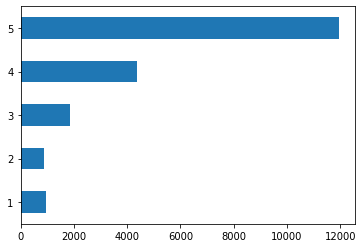

In [120]:
df_amazon.rating.value_counts().sort_index().plot(kind = 'barh')

#Preprocessing

##Natural Language Toolkit

In [121]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [122]:
df_amazon['reviewText'].sample(3)

2537     It is a good family movie. It is about teams t...
12796    This is my favorite movie of all-time so of co...
837      Mel Gibson's film about the trasgression of Je...
Name: reviewText, dtype: object

## Lowercase all the words

In [123]:
df_amazon['clean_review'] = df_amazon['reviewText'].str.lower()

In [124]:
df_amazon.sample(1)

,reviewText,rating,clean_review
11592,This is a musical that I can sit down and watc...,5,this is a musical that i can sit down and watc...


## Remove punctuations

In [125]:
df_amazon['clean_review'] = df_amazon['clean_review'].str.replace('[^\w\s]','')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [126]:
df_amazon.sample(1)

,reviewText,rating,clean_review
1459,The only thing more disgusting than the violen...,1,the only thing more disgusting than the violen...


## Remove stopwords

In [127]:
stops = set(stopwords.words("english"))

In [128]:
df_amazon['clean_review'] = df_amazon['clean_review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stops)]))

In [129]:
df_amazon.sample(1)

,reviewText,rating,clean_review
2998,This movie puts me in the Christmas spirit eve...,4,movie puts christmas spirit every year main ch...


In [130]:
print(stopwords.words("english"))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

## Stem the text using snowball stemmer

In [131]:
stemmer = SnowballStemmer("english")

In [132]:
df_amazon['stemmed_review'] = df_amazon['clean_review'].apply(lambda x: [stemmer.stem(y) for y in x.split()])

In [133]:
df_amazon['clean_review'] = df_amazon['stemmed_review'].str.join(" ")

In [134]:
df_amazon.sample(1)

,reviewText,rating,clean_review,stemmed_review
5418,"A great movie, action , well acted, good story...",5,great movi action well act good stori ask good...,"[great, movi, action, well, act, good, stori, ..."


# Embeddings

## TF-IDF

In [135]:
feature_extraction = TfidfVectorizer(max_features=2000)
X_tfidf = feature_extraction.fit_transform(df_amazon['clean_review'].values)

In [136]:
gc.collect()

33991

In [137]:
### Create sequence
vocabulary_size = 20000
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(df_amazon['clean_review'])

In [138]:
sequences = tokenizer.texts_to_sequences(df_amazon['clean_review'])
data = pad_sequences(sequences, maxlen=50)

##GloVe Embeddings

In [139]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2022-06-19 09:45:05--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-06-19 09:45:05--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-06-19 09:45:05--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove

In [140]:
!unzip glove*.zip

Archive:  glove.6B.zip
replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [141]:
!ls

glove.6B.100d.txt  glove.6B.50d.txt  reviews_Movies_and_TV_5.json
glove.6B.200d.txt  glove.6B.zip      reviews_Movies_and_TV_5.json.gz
glove.6B.300d.txt  glove.6B.zip.1    sample_data


In [142]:
embeddings_index_glove = dict()

In [143]:
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index_glove[word] = coefs
f.close()

In [144]:
vocabulary_size = 20000

In [145]:
embedding_matrix_glove = np.zeros((vocabulary_size, 100))
for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        embedding_vector = embeddings_index_glove.get(word)
        if embedding_vector is not None:
            embedding_matrix_glove[index] = embedding_vector

In [146]:
len(embeddings_index_glove)

400000

## Word2Vec

In [147]:
w2vec_gensim  = api.load('glove-wiki-gigaword-100')

In [148]:
vector_size = 100
embedding_matrix_w2v = np.zeros((vocabulary_size ,vector_size))
embedding_matrix_w2v.shape

(20000, 100)

In [149]:
for word, index in tokenizer.word_index.items():
    if index < vocabulary_size: # since index starts with zero 
        if word in w2vec_gensim.wv.vocab:
            embedding_matrix_w2v[index] = w2vec_gensim[word]
        else:
            embedding_matrix_w2v[index] = np.zeros(100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until


# Modelling

##Hyper Parametres

In [150]:
epoch = 20
batch = 128
predicted_rating = 0.75
real_rating = 1 - predicted_rating

## KNN with TF-IDF Embeddings

In [151]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf.todense(), df_amazon['rating'], test_size=0.2, stratify=df_amazon['rating'], random_state=42)

In [152]:
neigh = KNeighborsClassifier(n_neighbors=10)
neigh.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


KNeighborsClassifier(n_neighbors=10)

In [153]:
gnb_preds = neigh.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


In [154]:
pd.Series(gnb_preds).value_counts()

5    3923
4      57
3      10
1       6
2       4
dtype: int64

###Combination layer

In [155]:
y_test_combined_tfidf_knn = combine_preds_real(gnb_preds, y_test, predicted_rating, real_rating, prob=False)

In [156]:
y_test

6483     5
9259     5
18694    4
18580    5
17183    3
        ..
13703    5
13722    5
3108     5
11577    3
4883     4
Name: rating, Length: 4000, dtype: int64

In [157]:
y_test_combined_tfidf_knn

6483     5
9259     5
18694    4
18580    5
17183    4
        ..
13703    5
13722    5
3108     5
11577    4
4883     4
Name: rating, Length: 4000, dtype: int64

### Metrices

In [158]:
mse_combined_tfidf_knn, mae_combined_tfidf_knn = metric_function(y_test, y_test_combined_tfidf_knn, prob=False)

In [159]:
mse_combined_tfidf_knn, mae_combined_tfidf_knn

(0.8408329203831163, 0.3325)

In [160]:
mse_tfidf_knn, mae_tfidf_knn = metric_function(y_test, gnb_preds, prob=False)

In [161]:
mse_tfidf_knn, mae_tfidf_knn

(1.3172888825159044, 0.72575)

## Neural Network with TF-IDF

In [162]:
encoder = LabelEncoder()
encoder.fit(pd.concat([y_train, y_test]))
encoded_y_train = encoder.transform(y_train)
encoded_y_test = encoder.transform(y_test)
# convert integers to dummy variables (i.e. one hot encoded)
y_train_dummy = np_utils.to_categorical(encoded_y_train)
y_test_dummy = np_utils.to_categorical(encoded_y_test)

In [163]:
X_train.shape

(16000, 2000)

In [164]:
## create model
model_tfidf_nn = Sequential()
model_tfidf_nn.add(Dense(128, input_dim=2000, activation='relu'))
model_tfidf_nn.add(Dropout(0.3))
model_tfidf_nn.add(Dense(8, activation='relu'))
model_tfidf_nn.add(Dropout(0.3))
model_tfidf_nn.add(Dense(5, activation='softmax'))

In [165]:
model_tfidf_nn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [166]:
model_tfidf_nn.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 128)               256128    
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 8)                 1032      
                                                                 
 dropout_6 (Dropout)         (None, 8)                 0         
                                                                 
 dense_11 (Dense)            (None, 5)                 45        
                                                                 
Total params: 257,205
Trainable params: 257,205
Non-trainable params: 0
_________________________________________________________________


In [167]:
model_tfidf_nn.fit(X_train, y_train_dummy, validation_data=(X_test, y_test_dummy), epochs = 1, batch_size=512)

32/32 [==============================] - 1s 26ms/step - loss: 1.4964 - accuracy: 0.5084 - val_loss: 1.3169 - val_accuracy: 0.5985


###Combination layer

In [168]:
y_test_combined_tfidf_nn = combine_preds_real(model_tfidf_nn.predict(X_test), y_test, predicted_rating, real_rating, prob=True)
mse_combined_tfidf_nn, mae_combined_tfidf_nn = metric_function(y_test, y_test_combined_tfidf_nn, prob=False)

###Metrics

In [169]:
mse_tfidf_nn, mae_tfidf_nn = metric_function(y_test_dummy, model_tfidf_nn.predict(X_test), prob=True)

In [170]:
mse_tfidf_nn, mae_tfidf_nn

(1.3192801067248758, 0.724)

## Glove CNN LSTM

In [171]:
encoder = LabelEncoder()
encoder.fit(df_amazon['rating'])
encoded_Y = encoder.transform(df_amazon['rating'])
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

In [172]:
X_train_embedding, X_test_embedding, y_train_embedding, y_test_embedding = train_test_split(data, dummy_y, test_size=0.2, stratify=dummy_y, random_state=42)

In [173]:
## create model
model_glove_cnn = Sequential()
model_glove_cnn.add(Embedding(vocabulary_size, 100, input_length=50, weights=[embedding_matrix_glove], trainable=False))
model_glove_cnn.add(Dropout(0.2))
model_glove_cnn.add(Conv1D(256, 5, activation='relu'))
model_glove_cnn.add(MaxPooling1D(pool_size=4))
# model_glove_cnn.add(Conv1D(128, 5, activation='relu'))
# model_glove_cnn.add(MaxPooling1D(pool_size=4))
model_glove_cnn.add(LSTM(20))
model_glove_cnn.add(Dense(5, activation='softmax'))

In [174]:
model_glove_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[rmse,'mae'])

In [175]:
model_glove_cnn.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 50, 100)           2000000   
                                                                 
 dropout_7 (Dropout)         (None, 50, 100)           0         
                                                                 
 conv1d_3 (Conv1D)           (None, 46, 256)           128256    
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 11, 256)          0         
 1D)                                                             
                                                                 
 lstm_6 (LSTM)               (None, 20)                22160     
                                                                 
 dense_12 (Dense)            (None, 5)                 105       
                                                      

In [176]:
history_model_glove_cnn = model_glove_cnn.fit(X_train_embedding, y_train_embedding, validation_data=(X_test_embedding, y_test_embedding), epochs = epoch + 1, batch_size=64)

Epoch 1/21
250/250 [==============================] - 18s 64ms/step - loss: 1.1359 - rmse: 0.3119 - mae: 0.2310 - val_loss: 1.0998 - val_rmse: 0.3008 - val_mae: 0.2226
Epoch 2/21
250/250 [==============================] - 14s 55ms/step - loss: 1.0787 - rmse: 0.2985 - mae: 0.2208 - val_loss: 1.0626 - val_rmse: 0.2964 - val_mae: 0.2196
Epoch 3/21
250/250 [==============================] - 14s 55ms/step - loss: 1.0289 - rmse: 0.2892 - mae: 0.2137 - val_loss: 1.0534 - val_rmse: 0.2912 - val_mae: 0.2125
Epoch 4/21
250/250 [==============================] - 14s 57ms/step - loss: 0.9669 - rmse: 0.2763 - mae: 0.2036 - val_loss: 1.0479 - val_rmse: 0.2820 - val_mae: 0.2071
Epoch 5/21
250/250 [==============================] - 14s 55ms/step - loss: 0.9018 - rmse: 0.2632 - mae: 0.1936 - val_loss: 1.0520 - val_rmse: 0.2863 - val_mae: 0.2103
Epoch 6/21
250/250 [==============================] - 14s 55ms/step - loss: 0.8316 - rmse: 0.2470 - mae: 0.1812 - val_loss: 1.0848 - val_rmse: 0.2999 - val_mae:

###Plotting

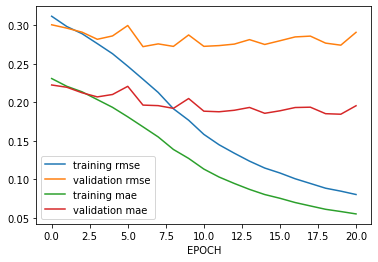

In [177]:
pyplot.plot(history_model_glove_cnn.history['rmse'], label='training rmse')
pyplot.plot(history_model_glove_cnn.history['val_rmse'], label='validation rmse')
pyplot.plot(history_model_glove_cnn.history['mae'], label='training mae')
pyplot.plot(history_model_glove_cnn.history['val_mae'], label='validation mae')
pyplot.legend()
pyplot.xlabel('EPOCH')
pyplot.show()

###Combination layer 

In [178]:
y_test_combined_glove_cnn = combine_preds_real(model_glove_cnn.predict(X_test_embedding), y_test, predicted_rating, real_rating, prob=True)
mse_combined_glove_cnn, mae_combined_glove_cnn = metric_function(y_test, y_test_combined_glove_cnn, prob=False)

###Metrics

In [179]:
mse_combined_glove_cnn, mae_combined_glove_cnn

(1.597811002590732, 1.291)

## GloVe RNN LSTM

In [180]:
## create model
model_glove_rnn = Sequential()
model_glove_rnn.add(Embedding(vocabulary_size, 100, input_length=50, weights=[embedding_matrix_glove], trainable=False))
model_glove_rnn.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model_glove_rnn.add(Dense(5, activation='softmax'))

In [181]:
model_glove_rnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[rmse,'mae'])

In [182]:
model_glove_rnn.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 50, 100)           2000000   
                                                                 
 lstm_7 (LSTM)               (None, 100)               80400     
                                                                 
 dense_13 (Dense)            (None, 5)                 505       
                                                                 
Total params: 2,080,905
Trainable params: 80,905
Non-trainable params: 2,000,000
_________________________________________________________________


In [183]:
history_model_glove_rnn = model_glove_rnn.fit(X_train_embedding, y_train_embedding, validation_data=(X_test_embedding, y_test_embedding), epochs = epoch + 1, batch_size=64)

Epoch 1/21
250/250 [==============================] - 32s 121ms/step - loss: 1.1224 - rmse: 0.3097 - mae: 0.2290 - val_loss: 1.0709 - val_rmse: 0.3100 - val_mae: 0.2288
Epoch 2/21
250/250 [==============================] - 30s 122ms/step - loss: 1.0482 - rmse: 0.2950 - mae: 0.2167 - val_loss: 1.0268 - val_rmse: 0.2902 - val_mae: 0.2108
Epoch 3/21
250/250 [==============================] - 30s 119ms/step - loss: 1.0181 - rmse: 0.2895 - mae: 0.2120 - val_loss: 1.0127 - val_rmse: 0.2850 - val_mae: 0.2086
Epoch 4/21
250/250 [==============================] - 31s 125ms/step - loss: 0.9990 - rmse: 0.2852 - mae: 0.2086 - val_loss: 1.0134 - val_rmse: 0.2850 - val_mae: 0.2047
Epoch 5/21
250/250 [==============================] - 30s 122ms/step - loss: 0.9828 - rmse: 0.2818 - mae: 0.2058 - val_loss: 1.0162 - val_rmse: 0.2764 - val_mae: 0.1978
Epoch 6/21
250/250 [==============================] - 30s 120ms/step - loss: 0.9604 - rmse: 0.2776 - mae: 0.2022 - val_loss: 1.0120 - val_rmse: 0.2922 - va

###Plotting

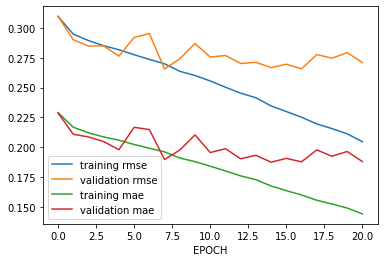

In [184]:
pyplot.plot(history_model_glove_rnn.history['rmse'], label='training rmse')
pyplot.plot(history_model_glove_rnn.history['val_rmse'], label='validation rmse')
pyplot.plot(history_model_glove_rnn.history['mae'], label='training mae')
pyplot.plot(history_model_glove_rnn.history['val_mae'], label='validation mae')
pyplot.legend()
pyplot.xlabel('EPOCH')
pyplot.show()

###Combination layer

In [185]:
y_test_combined_glove_rnn = combine_preds_real(model_glove_rnn.predict(X_test_embedding), y_test, predicted_rating, real_rating, prob=True)
mse_combined_glove_rnn, mae_combined_glove_rnn = metric_function(y_test, y_test_combined_glove_rnn, prob=False)

###Metrics

In [186]:
mse_combined_glove_rnn, mae_combined_glove_rnn

(1.5453963892801097, 1.22975)

##Word2Vec CNN LSTM

In [187]:
## create model
model_w2v_cnn = Sequential()
model_w2v_cnn.add(Embedding(vocabulary_size, 100, input_length=50, weights=[embedding_matrix_w2v], trainable=False))
model_w2v_cnn.add(Dropout(0.2))
model_w2v_cnn.add(Conv1D(256, 5, activation='relu'))
model_w2v_cnn.add(MaxPooling1D(pool_size=4))
# model_w2v_cnn.add(Conv1D(128, 5, activation='relu'))
# model_w2v_cnn.add(MaxPooling1D(pool_size=4))
model_w2v_cnn.add(LSTM(20))
model_w2v_cnn.add(Dense(5, activation='softmax'))

In [188]:
model_w2v_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[rmse,'mae'])

In [189]:
history_model_w2v_cnn = model_w2v_cnn.fit(X_train_embedding, y_train_embedding, validation_data=(X_test_embedding, y_test_embedding), epochs = epoch + 1, batch_size=batch)

Epoch 1/21
125/125 [==============================] - 16s 111ms/step - loss: 1.1445 - rmse: 0.3144 - mae: 0.2331 - val_loss: 1.1024 - val_rmse: 0.3064 - val_mae: 0.2276
Epoch 2/21
125/125 [==============================] - 12s 97ms/step - loss: 1.0792 - rmse: 0.2996 - mae: 0.2214 - val_loss: 1.0581 - val_rmse: 0.2912 - val_mae: 0.2121
Epoch 3/21
125/125 [==============================] - 12s 98ms/step - loss: 1.0299 - rmse: 0.2889 - mae: 0.2130 - val_loss: 1.0491 - val_rmse: 0.3012 - val_mae: 0.2236
Epoch 4/21
125/125 [==============================] - 13s 104ms/step - loss: 0.9743 - rmse: 0.2780 - mae: 0.2048 - val_loss: 1.0619 - val_rmse: 0.2744 - val_mae: 0.1974
Epoch 5/21
125/125 [==============================] - 12s 99ms/step - loss: 0.9248 - rmse: 0.2664 - mae: 0.1958 - val_loss: 1.0527 - val_rmse: 0.2746 - val_mae: 0.1980
Epoch 6/21
125/125 [==============================] - 12s 98ms/step - loss: 0.8612 - rmse: 0.2514 - mae: 0.1847 - val_loss: 1.0550 - val_rmse: 0.2772 - val_ma

###plotting

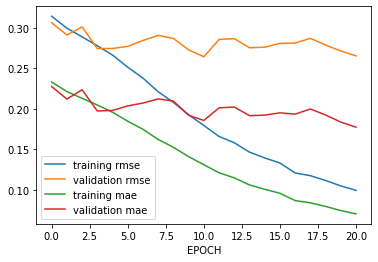

In [190]:
pyplot.plot(history_model_w2v_cnn.history['rmse'], label='training rmse')
pyplot.plot(history_model_w2v_cnn.history['val_rmse'], label='validation rmse')
pyplot.plot(history_model_w2v_cnn.history['mae'], label='training mae')
pyplot.plot(history_model_w2v_cnn.history['val_mae'], label='validation mae')
pyplot.legend()
pyplot.xlabel('EPOCH')
pyplot.show()

###Combination layer

In [191]:
y_test_combined_w2v_cnn = combine_preds_real(model_w2v_cnn.predict(X_test_embedding), y_test, predicted_rating, real_rating, prob=True)
mse_combined_w2v_cnn, mae_combined_w2v_cnn = metric_function(y_test, y_test_combined_w2v_cnn, prob=False)

###Metrics

In [192]:
mse_combined_w2v_cnn, mae_combined_w2v_cnn

(1.4281106399715675, 1.147)

## Word2Vec RNN LSTM

In [193]:
## create model
model_w2v_rnn = Sequential()
model_w2v_rnn.add(Embedding(vocabulary_size, 100, input_length=50, weights=[embedding_matrix_w2v], trainable=False))
model_w2v_rnn.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model_w2v_rnn.add(Dense(5, activation='softmax'))

In [194]:
model_w2v_rnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[rmse,'mae'])

In [195]:
history_model_w2v_rnn = model_w2v_rnn.fit(X_train_embedding, y_train_embedding, validation_data=(X_test_embedding, y_test_embedding), epochs = epoch + 1, batch_size=batch)

Epoch 1/21
125/125 [==============================] - 26s 186ms/step - loss: 1.1288 - rmse: 0.3112 - mae: 0.2304 - val_loss: 1.0564 - val_rmse: 0.2965 - val_mae: 0.2174
Epoch 2/21
125/125 [==============================] - 23s 183ms/step - loss: 1.0599 - rmse: 0.2972 - mae: 0.2187 - val_loss: 1.0380 - val_rmse: 0.3026 - val_mae: 0.2243
Epoch 3/21
125/125 [==============================] - 23s 186ms/step - loss: 1.0288 - rmse: 0.2918 - mae: 0.2140 - val_loss: 1.0301 - val_rmse: 0.2748 - val_mae: 0.1990
Epoch 4/21
125/125 [==============================] - 23s 181ms/step - loss: 1.0192 - rmse: 0.2884 - mae: 0.2116 - val_loss: 1.0444 - val_rmse: 0.2953 - val_mae: 0.2107
Epoch 5/21
125/125 [==============================] - 23s 181ms/step - loss: 0.9958 - rmse: 0.2849 - mae: 0.2082 - val_loss: 1.0169 - val_rmse: 0.2783 - val_mae: 0.2026
Epoch 6/21
125/125 [==============================] - 23s 186ms/step - loss: 0.9816 - rmse: 0.2818 - mae: 0.2058 - val_loss: 1.0086 - val_rmse: 0.2759 - va

###plotting

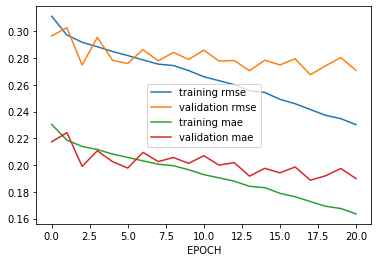

In [196]:
pyplot.plot(history_model_w2v_rnn.history['rmse'], label='training rmse')
pyplot.plot(history_model_w2v_rnn.history['val_rmse'], label='validation rmse')
pyplot.plot(history_model_w2v_rnn.history['mae'], label='training mae')
pyplot.plot(history_model_w2v_rnn.history['val_mae'], label='validation mae')
pyplot.legend()
pyplot.xlabel('EPOCH')
pyplot.show()

###Combination layer

In [197]:
y_test_combined_w2v_rnn = combine_preds_real(model_w2v_rnn.predict(X_test_embedding), y_test, predicted_rating, real_rating, prob=True)
mse_combined_w2v_rnn, mae_combined_w2v_rnn = metric_function(y_test, y_test_combined_w2v_rnn, prob=False)

###Metrics

In [198]:
mse_combined_w2v_rnn, mae_combined_w2v_rnn

(1.4575664650368434, 1.157)